<a href="https://colab.research.google.com/github/myzw-ysk/Data-analysis/blob/main/covid19_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# https://qiita.com/tsubauaaa/items/8411a22465811ec2ee11
# PCR陽性者数データ
# 厚生労働省オープンデータを利用
# https://www.mhlw.go.jp/stf/covid-19/open-data.html
data1 = pd.read_csv('drive/My Drive/Data/covid19/newly_confirmed_cases_daily.csv')
# PCR検査実施人数データ
# 厚生労働省オープンデータを利用
# https://www.mhlw.go.jp/stf/covid-19/open-data.html
data2 = pd.read_csv('drive/My Drive/Data/covid19/pcr_tested_daily.csv').fillna(0)

In [4]:
#都道府県の横軸へ
#https://qiita.com/indx_s/items/1c21d6c1a0fa733b026d

#日付のみ
df_day = data1.copy()
df_day.drop(df_day.columns[[1, 2]],axis=1,inplace=True)
df_day.drop_duplicates(inplace=True)

# 47都道府県の1日ごとの感染者数をdf_dayに1列ずつmerge()
for pref in data1['Prefecture'].unique():
    df_pref = data1[data1['Prefecture']==pref]
    # 列名:Newly confirmed casesを各都道府県の名前にrename()
    df_pref = df_pref.rename(columns={'Newly confirmed cases' : pref})
    df_pref.drop(df_pref.columns[1],axis=1,inplace=True)
    df_day = pd.merge(df_day, df_pref, on='Date')

In [5]:
#ガバガバPCR数の追加
data2 = data2.rename(columns={'日付' : 'Date'})
data2 = data2.rename(columns={'PCR 検査実施件数(単日)' : 'pcr_tested'})
data = pd.merge(df_day,data2,on='Date',how='outer').fillna(0)

In [71]:
covid19_data = data.drop(['Date'], axis=1)
covid19_data = covid19_data.values.astype(float)
#covid19_data = np.log1p(covid19_data)

# 直近30日をテストデータにする
test_data_size = 30
train_data = covid19_data[:-test_data_size]
test_data = covid19_data[-test_data_size:]

In [72]:
# データセットの正規化を行う。最小値0と最大値1の範囲で行う。
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
train_data_normalized = scaler.fit_transform(train_data)

In [73]:
# Tensor型に変換
train_data_normalized = torch.FloatTensor(train_data_normalized)

In [74]:
# シーケンスに沿ったデータを作成する関数
def make_sequence_data(input_data, num_sequence):
    # シーケンスデータとラベルデータの器
    data = []
    # 全体のデータ数取得
    num_data = len(input_data)
    # 全体からシーケンス分引いた数までループする
    for i in range(num_data - num_sequence):
        # 1個ずらして、シーケンス分のデータを取得していく
        seq_data = input_data[i:i+num_sequence]
        # シーケンスの次の要素のデータ(ラベルデータとして1個目の陽性者数のみ)を取得していく
        target_data = input_data[:,:][i+num_sequence:i+num_sequence+1] #Tokyo is 13.
        # シーケンスデータとラベルデータをタプルとして取得していく
        data.append((seq_data, target_data))

    return data

In [87]:
# シーケンス長は30日とする
seq_length = 30
# train_seq_data=最初のデータを1個ずらしてシーケンス分のデータ(時系列の学習データ群)、train_target=train_seq_dataの次のデータ(ラベルデータ)
train_seq_data = make_sequence_data(train_data_normalized, seq_length)

In [88]:
class LSTM(nn.Module):
    def __init__(self, input_size=49, hidden_layer_size=100, output_size=49):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_layer_size, batch_first=True)

        self.linear = nn.Linear(in_features=hidden_layer_size, out_features=output_size)

    def forward(self, x):
        # LSTMのinputは(batch_size, seq_len, input_size)にする
        # LSTMのoutputは(batch_size, seq_len, hidden_layer_size)となる
        # hidden stateとcell stateにはNoneを渡して0ベクトルを渡す
        lstm_out, (hn, cn) = self.lstm(x, None)
        # Linearのinputは(N,∗,in_features)にする
        # lstm_out(batch_size, seq_len, hidden_layer_size)のseq_len方向の最後の値をLinearに入力する
        prediction = self.linear(lstm_out[:, -1, :])
        return prediction

In [89]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

model = LSTM()
model.to(device)

LSTM(
  (lstm): LSTM(49, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=49, bias=True)
)

In [90]:
# 損失関数と最適化関数を定義
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [91]:
epochs = 50
losses = []
for i in range(epochs):
    for seq, labels in train_seq_data:
        # seq, labelsのshapeは(seq_length, 特徴量)なのでLSTMに渡すために(batch, seq_length, 特徴量)にする。(batch=1)
        seq, labels = torch.unsqueeze(seq, 0), torch.unsqueeze(labels, 0)
        seq, labels = seq.to(device), labels.to(device)
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = criterion(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    losses.append(single_loss.item())
    print(f'epoch: {i}, loss : {single_loss.item()}')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1, 49])) that is different to the input size (torch.Size([1, 49])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0, loss : 0.019072914496064186
epoch: 1, loss : 0.0202376339584589
epoch: 2, loss : 0.018913185223937035
epoch: 3, loss : 0.019721392542123795
epoch: 4, loss : 0.021300705149769783
epoch: 5, loss : 0.030087456107139587
epoch: 6, loss : 0.027117718011140823
epoch: 7, loss : 0.0216648131608963
epoch: 8, loss : 0.021460719406604767
epoch: 9, loss : 0.02271377667784691
epoch: 10, loss : 0.021587811410427094
epoch: 11, loss : 0.021566294133663177
epoch: 12, loss : 0.020700151100754738
epoch: 13, loss : 0.020071517676115036
epoch: 14, loss : 0.020107388496398926
epoch: 15, loss : 0.021431684494018555
epoch: 16, loss : 0.022301191464066505
epoch: 17, loss : 0.020359614863991737
epoch: 18, loss : 0.020713606849312782
epoch: 19, loss : 0.02188056707382202
epoch: 20, loss : 0.021982602775096893
epoch: 21, loss : 0.022365165874361992
epoch: 22, loss : 0.023487236350774765
epoch: 23, loss : 0.02067984826862812
epoch: 24, loss : 0.022283688187599182
epoch: 25, loss : 0.020719751715660095
epo

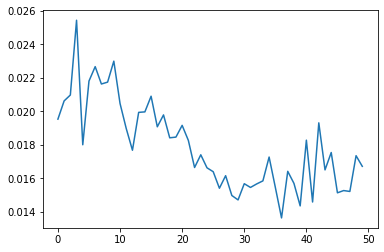

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(losses)

In [92]:
# テストデータの正規化を行う。最小値0と最大値1の範囲で行ってTensor型に変換する。
test_data_normalized = scaler.fit_transform(test_data)
test_data_normalized = torch.FloatTensor(test_data_normalized)
# 予測するためのデータの最初のseq_length分はtrain_dataを使う
test_inputs = train_data_normalized[-seq_length:].tolist()

In [93]:
# モデルを評価モードとする
model.eval()
# 予測値を入れるリスト
test_outputs = []
for i in range(test_data_size):
    seq = torch.FloatTensor(test_inputs[-seq_length:])
    seq = torch.unsqueeze(seq, 0)
    seq = seq.to(device)
    with torch.no_grad():
        test_inputs.append(test_data_normalized.tolist()[i])
        #test_outputs.append(model(seq).item())
        test_outputs.append(model(seq).tolist())

In [94]:
np_test_outputs = np.array(test_outputs).reshape(-1,49)
output_scale = np_test_outputs
# 列方向に同じ値を追加して(30, 49)にする
#for  i in range(49-1):
#  output_scale=np.hstack((output_scale,np_test_outputs))
actual_predictions = scaler.inverse_transform(output_scale)
#actual_predictions = np.expm1(scaler.inverse_transform(output_scale))

In [95]:
x = np.arange(len(data)-test_data_size, len(data), 1)
print(x)

[623 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638 639 640
 641 642 643 644 645 646 647 648 649 650 651 652]


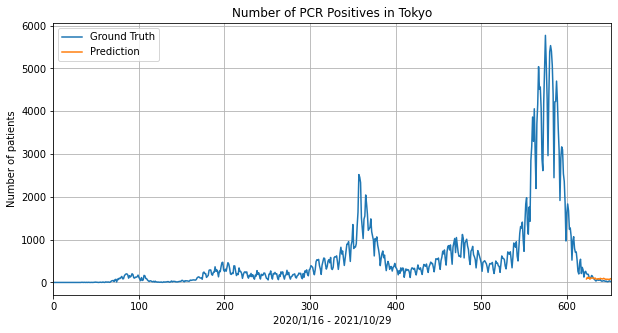

In [96]:
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 10
fig_size[1] = 5
plt.rcParams['figure.figsize'] = fig_size

plt.title('Number of PCR Positives in Tokyo')
plt.ylabel('Number of patients')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(data['Tokyo'], label='Ground Truth')
plt.plot(x, actual_predictions[:,13], label='Prediction')
plt.xlabel('2020/1/16 - 2021/10/29')
plt.legend()
plt.show()

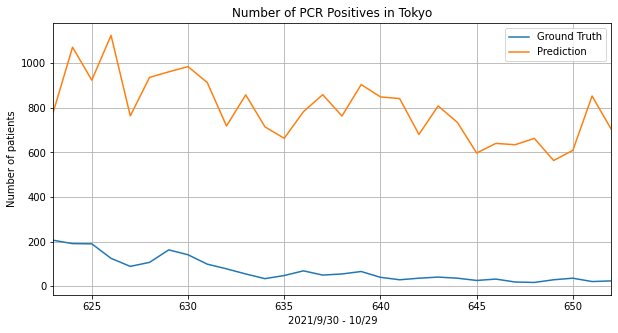

In [97]:
plt.title('Number of PCR Positives in Tokyo')
plt.ylabel('Number of patients')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(x, data['Tokyo'][-1*test_data_size:], label='Ground Truth')
plt.plot(x, actual_predictions[:,0], label='Prediction')
plt.xlabel('2021/9/30 - 10/29')
plt.legend()
plt.show()

In [ ]:
#https://qiita.com/yamaday/items/7ba01eafa76cc877a6c7
#あとは未来の日の予測タスクが考えられるが、途中から予測データを学習データに使うから当然ながら精度は悪くなりそう